<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Результаты-моделирования-+-график-полученных-F1-на-тестовой-выборке." data-toc-modified-id="Результаты-моделирования-+-график-полученных-F1-на-тестовой-выборке.-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Результаты моделирования + график полученных F1 на тестовой выборке.</a></span></li></ul></li><li><span><a href="#Лемматизация-nltk-+-TfidfTransformer()." data-toc-modified-id="Лемматизация-nltk-+-TfidfTransformer().-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Лемматизация nltk + TfidfTransformer().</a></span><ul class="toc-item"><li><span><a href="#Результаты-моделирования-+-график-полученных-F1-на-тестовой-выборке." data-toc-modified-id="Результаты-моделирования-+-график-полученных-F1-на-тестовой-выборке.-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Результаты моделирования + график полученных F1 на тестовой выборке.</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-адекватность" data-toc-modified-id="Проверка-модели-на-адекватность-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Проверка модели на адекватность</a></span></li><li><span><a href="#Вывод." data-toc-modified-id="Вывод.-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод.</a></span></li></ul></div>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Инструментом будет модель, которую необходимо обучить модель классифицировать комментарии на позитивные и негативные. В этом поможет набор данных с разметкой о токсичности правок.

**Задача:** Подобрать модель с F1 не меньше 0.75. 

## Подготовка

Импортируем библиотеки для работы.

In [1]:
from catboost import CatBoostClassifier
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords 
import nltk
nltk.download('stopwords')
import nltk
nltk.download('averaged_perceptron_tagger')
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from tqdm import notebook
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️ <br>
<font color='green'>Здорово, что все импорты находятся в одной ячейке.<br>
Если хочешь сделать ещё лучше, соблюдай стандарт PEP-8, разбей импорты на функциональные группы, раздели группы пустой строкой. Можно в каждой группе отсортировать импорты в алфавитном порядке.<br>
Ссылка для ознакомления: https://pythonworld.ru/osnovy/pep-8-rukovodstvo-po-napisaniyu-koda-na-python.html
</font>

Откроем данные с комментариями и загрузим их в dataframe df.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

In [3]:
df.head(5)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


Посмотрим на пропуски в данных.

**Вывод по пропускам:** Пропусков в данных нет.

Проверим файл на дубликаты.

In [4]:
df.duplicated().sum()

0

**Вывод по дубликатам:** Дубликатов в данных нет.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

Посмотрим на распределение по классам таргета.

In [5]:
df['toxic'].value_counts()

0    143106
1     16186
Name: toxic, dtype: int64

Посмотрим на распределение по барчарту.

<AxesSubplot:ylabel='Comments: 1- toxic, 0 - ok'>

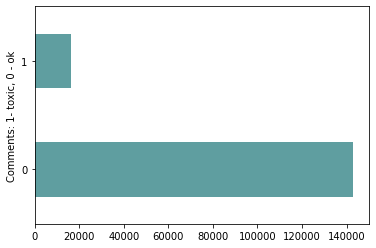

In [6]:
df['toxic'].value_counts().plot.barh(color='CadetBlue', xlabel='Comments: 1- toxic, 0 - ok')

**Вывод по распределению класов:** 1 в таргете, то есть косичных комментариев, значительно меньше чем 0. Для Вики-шопа это, конечно, хорошо. А нам нужно будет учесть это при подборе модели с лучшим F1. 

Сделаем словари по гиперпараметрам моделей для валидаций с помощью GridSearchCV.

In [7]:
params_LR = {'C': [10],
             'solver' : ['lbfgs'], 
             'class_weight' : ['auto', 'balanced', {0:1,1:4}]}

params_DT = {'max_depth': [5, 20, 50]} 

params_RF = {'n_estimators': [5, 20, 50],
             'max_depth': [10, 20]} 

params_сat = {"eval_metric" : 'TotalF1',
              "random_seed": 911,
              "learning_rate": 0.028,
             }

In [8]:
params_ = [params_LR, params_DT, params_RF, params_сat]
models_ = [LogisticRegression(random_state=911, max_iter=100),
           DecisionTreeClassifier(random_state=911), 
           RandomForestClassifier(random_state=911), 
           CatBoostClassifier(**params_сat)]

f1_scores = []
model_best_estimator=[]
f1_scores_test=[]
model_best_estimator_test=[]

# Лемматизация nltk + TfidfTransformer().

In [25]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')

EDA мы уже проводили. Разобъем данные на X - фичи(признаки) и Y - таргент(целевой признак).

In [4]:
# df=df[:50000]

In [10]:
X = df['text']
Y = df['toxic']

In [11]:
del df

Разобъем данные на выборки.

Запустим лемматизацию с помощью WordNetLemmatizer.
Чистим каждый комментарий: удаляем нунужные символы, побелы, знаки пунктуации и прочее. Сводим к нижнему регистру. 
Запускаем лемматизацию.
На последнем шаге цикла текст соединяется пробелами и добавляется в общий список лемматизированного текста

In [12]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
documents = []
stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    document = re.sub(r'\W', ' ', str(X[sen]))
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    document = re.sub(r'^b\s+', '', document)
    document = document.lower()
    document = document.split()
    document = [stemmer.lemmatize(w, get_wordnet_pos(w)) for w in document]
    document = ' '.join(document)
    documents.append(document)

Создаем мешок слов. Ограничим максимальное число признаков 1500 словами. Обучать выборку на редкоиспользуемых словах безсмысленно.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(documents, Y, train_size=0.6, random_state=911, stratify=Y)

In [16]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=0.5, random_state=911, stratify=y_test)

In [17]:
vectorizer = CountVectorizer( stop_words=stopwords.words('english')) 
X_train = vectorizer.fit_transform(X_train) 

In [18]:
X_val = vectorizer.transform(X_val)
X_test = vectorizer.transform(X_test)

Построим матрицу TF-IDF c помощью TfidfTransformer().

In [19]:
tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train) #.toarray()

In [20]:
X_val = tfidfconverter.transform(X_val)
X_test = tfidfconverter.transform(X_test)

Запустим обучение. Список моделей, параметров, а также функция для LR, DT и RF у нас есть. Писали их при запуске в BERT. Воспользуемся повторно.

In [21]:
for i in range(1):
    print(models_[i])
    score, estimator= modeling(models_[i],params_[i],
                       X_train,y_train,X_val,y_val)
    
    f1_scores.append(round(score,2))
    model_best_estimator.append(estimator)
    print(f'F1 score: {score}') 
    print(f'Best_estimator: {model_best_estimator[i]}')
    print()

LogisticRegression(random_state=911)
F1 score: 0.777151799687011
Best_estimator: LogisticRegression(C=10, class_weight={0: 1, 1: 4}, random_state=911)



Лучшие результаты дала LogisticRegression. Посмотрим на данные на тесте по лучшей модели: 

In [22]:
model=model_best_estimator[0]
predicted_test = model.predict(X_test)
f1_score_test = f1_score(y_test, predicted_test, average='binary')
f1_scores_test.append(round(f1_score_test,2))
model_best_estimator_test.append(models_[0])
print(f'{models_[0]} F1 score на тесте : {f1_score_test}')

LogisticRegression(random_state=911) F1 score на тесте : 0.7758241758241758


Запустим CatBoost:

In [23]:
models_[3] = CatBoostClassifier(**params_сat)
models_[3].fit(X_train,y_train, eval_set =(X_val,y_val),verbose=False, plot=True)
predicted_test = models_[3].predict(X_test)
f1_score_ = f1_score(y_test, predicted_test, average='binary')
f1_scores_test.append(round(f1_score_,2))
model_best_estimator_test.append(models_[3])
print(f'{models_[3]} F1 score: {f1_score_}')

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

<catboost.core.CatBoostClassifier object at 0x7fe239501520> F1 score: 0.7180358829084043


### Результаты моделирования + график полученных F1 на тестовой выборке.

Загрузим данные в DataFrame. Постоим график, чтобы визуализировать полученные результаты: F1 на тестовых данных.

,F1_score test
LR,0.78
Cat,0.72


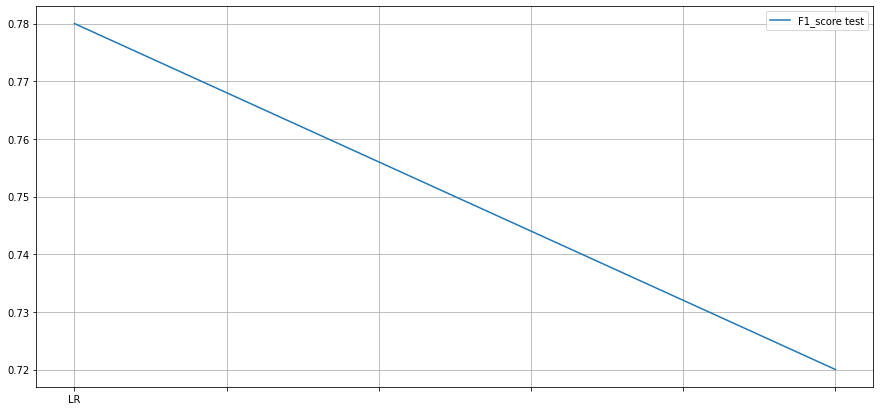

In [24]:
model_names = ['LR', 'Cat']
F1 =  {'F1_score test':  f1_scores_test }
results=pd.DataFrame(data=F1,index=model_names)
results.plot(figsize=(15,7))
plt.grid()
results

## Проверка модели на адекватность 

In [25]:
dummy = DummyClassifier(strategy='stratified', random_state = 100, constant = None)
dummy.fit(X_train, y_train)
dummy_pred = dummy.predict(X_test)
f1_score_ = f1_score(y_test, dummy_pred, average='binary')
print ('F1:', f1_score_)

F1: 0.0965813276099954


Полученное значение F1 c помощью DummyClassifier значительно ниже нашего на разных моделях. Значит, наша работа проделана не даром.

## Вывод.

**Вывод** Лучший F1 на тестовый выборке получен с помощью CatBoostClassifier(). Эту модель и будем рекомендовать заказчику для инструмента, который будет искать токсичные комментарии и отправлять их на модерацию.